### **Back to Colab**
**Unzip the file the contains the scraped instagram images.**


In [ ]:
!unzip \*.zip && rm *.zip

In [8]:
import os
classes = os.listdir('/content/demo-cats_dogs')
classes

['dogs', 'cats']

In [7]:
for name in classes:
  print(len(os.listdir('/content/demo-cats_dogs/'+name)))

40
40


### **Prepare Data**

**split it into Train, val and test for augmentaion.**

In [9]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import splitfolders
splitfolders.ratio("/content/demo-cats_dogs", output="/content/classes",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=True) # default values
    #ratio =(train,validation, and test respectivly)

Copying files: 80 files [00:00, 7958.83 files/s]


In [19]:
base = '/content/classes'
train_dir = os.path.join(base, 'train')
print(os.listdir(train_dir))
for name in classes:
  print(name+' :' + str(len(os.listdir(train_dir+ '/' + name))))


['dogs', 'cats']
dogs :28
cats :28


In [21]:
base = '/content/classes'
val_dir = os.path.join(base, 'val')
print(os.listdir(val_dir))
for name in classes:
  print(name+' :' + str(len(os.listdir(val_dir+ '/' + name))))

['dogs', 'cats']
dogs :8
cats :8


In [22]:
base = '/content/classes'
test_dir = os.path.join(base, 'test')
print(os.listdir(test_dir))
for name in classes:
  print(name+' :' + str(len(os.listdir(test_dir+ '/' + name))))

['dogs', 'cats']
dogs :4
cats :4


### **Data Augmentation**

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [62]:
target_shape = (224 , 224)  


image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='nearest')

train_gen = image_gen.flow_from_directory(
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size = target_shape,
                                                     class_mode='binary')

Found 56 images belonging to 2 classes.


In [63]:
val_gen = image_gen.flow_from_directory(
                                                     directory=val_dir,
                                                     shuffle=True,
                                                     target_size = target_shape,
                                                     class_mode='binary')

Found 16 images belonging to 2 classes.


In [64]:
test_gen = image_gen.flow_from_directory(
                                         directory = test_dir,
                                         shuffle = True,
                                         target_size = target_shape,
                                         class_mode = 'binary')

Found 8 images belonging to 2 classes.


**Show the augmented result**

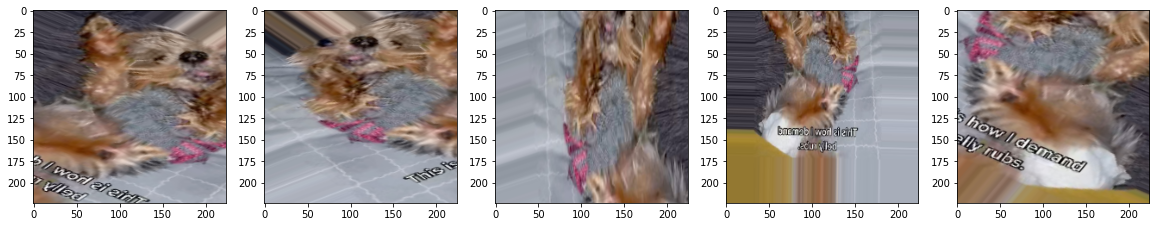

In [65]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
augmented_images = [train_gen[0][0][1] for i in range(5)]
plotImages(augmented_images)    

**See the labels of the augmented data.**


In [72]:
train_gen.class_indices

{'cats': 0, 'dogs': 1}

### **Build the Model**
**I am using MobileNet pretrained feature vector model(Transfer learning):**

https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


In [35]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

In [66]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
classes = 2
 
pretrained_model_without_last_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

model = tf.keras.Sequential([
  pretrained_model_without_last_layer,
  tf.keras.layers.Dense(classes)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [67]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.BinaryAccuracy()] )

In [68]:
epochs=50
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks= [early_stopping_monitor] 
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
2/2 [==============================] - 7s 3s/step - loss: 7.5104 - binary_accuracy: 0.4018 - val_loss: 4.6940 - val_binary_accuracy: 0.4375
Epoch 2/50
2/2 [==============================] - 3s 2s/step - loss: 7.2017 - binary_accuracy: 0.4732 - val_loss: 7.3654 - val_binary_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 3s 1s/step - loss: 7.7209 - binary_accuracy: 0.4911 - val_loss: 7.3108 - val_binary_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 3s 2s/step - loss: 7.5909 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 7.5748 - binary_accuracy: 0.5089 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 6/50
2/2 [==============================] - 3s 2s/step - loss: 7.5748 - binary_accuracy: 0.5089 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 3s 2s/step - loss: 7.5784 - binary_accuracy:

**>>> you can see that early stopping worked**

##### **Accuracy isn't perfect. Please consider the number of images scraped is not enough. To get better accuracy scrape more data, you can go back to (insta_image_scraper) notebook**

### **Loss, Acurracy and Evaluation**

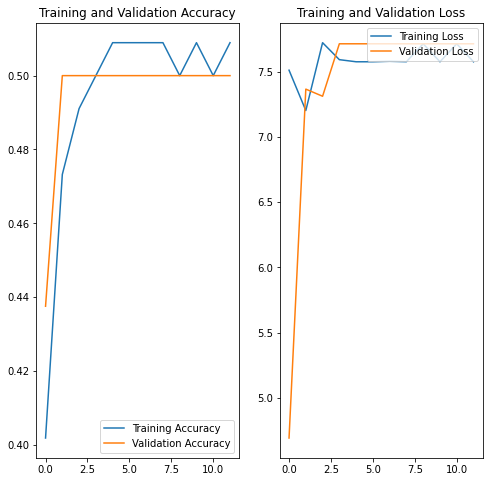

In [70]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(12) # No. of epoches already performed
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
model.evaluate(test_gen[0][0].tolist(),test_gen[0][1].astype(int).tolist()) # test_gen[0][1] contains imgs and test_gen[0][1] contains labels.

1/1 [==============================] - 1s 1s/step - loss: 7.7125 - binary_accuracy: 0.5000


[7.712474346160889, 0.5]

### **Save Model**

In [ ]:
#if you want to save your model if you get better accuracy
from keras.models import save_model
model.save("catas_dogs_classifier.h5")